In [2]:
import sys
sys.path.append('models/')
sys.path.append('eval/')

import glob
import itertools
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl
import torch
from scipy.stats import poisson, norm, laplace, lognorm

from class_mve_loss import MVELoss
from default_parameters import *
import util_eval
import util_gcnn, util_gat
import util_plot
from setup import *

%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 10})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
colors = {"laplace":"cornflowerblue", "tnorm":"mediumseagreen", "norm":"salmon", "poisson":"plum", 
          "norm_ens": "peru", "norm_homo":"gray"}
colors2 = {"laplace":"navy", "tnorm":"darkgreen", "norm":"red", "poisson":"purple", 
          "norm_ens": "saddlebrown", "norm_homo":"darkslategray"}
label = {"laplace":"LAP", "tnorm":"TG", "norm":"G", "poisson":"Pois", 
          "norm_ens": "GEns", "norm_homo":"HG"}

In [4]:
def evall(mean, std, target, dist, ax=None, label=""):
    
    if (dist == 'norm_ens')|(dist == 'norm_homo'):
        actual_dist = 'norm'
    else:
        actual_dist = dist
        
    test_out_predict, test_out_std = util_eval.post_process_dist(actual_dist, mean, std)
    a_test_mae, a_test_mse, _, _, _ = util_eval.eval_mean(mean, target, "")
    lb, ub = util_eval.post_process_pi(actual_dist, mean, std, z=0.95)
    a_mpiw, a_picp = util_eval.eval_pi(lb, ub, target)
    
    if (dist == 'norm') | (dist == 'norm_ens') | (dist == 'norm_homo'):
        a_test_loss = -np.sum(norm.logpdf(target, mean, std))/len(target)
    elif dist == 'laplace':
        a_test_loss = -np.sum(laplace.logpdf(target, mean, std))/len(target)
    elif dist == 'poisson':
        a_test_loss = -np.sum(poisson.logpmf(target, mean))/len(target)
    elif dist == 'tnorm':
        a_test_loss = -np.sum(norm.logpdf(target, mean, std)-np.log(1-norm.cdf(0,mean,std)))/len(target)

    num_points = len(target.flatten())
    emp = []

    p = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999])
    for i in p:
        if (dist == 'norm') | (dist == 'norm_ens') | (dist == 'norm_homo'):
            emp.append(np.sum(target <= norm.ppf(i, loc=mean, scale=std))/num_points)
        elif dist == 'laplace':
            emp.append(np.sum(target <= laplace.ppf(i, loc=mean, scale=std))/num_points)
        elif dist == 'poisson':
            emp.append(np.sum(target <= poisson.ppf(i, mu=mean))/num_points)
        elif dist == 'tnorm':
            emp.append(np.sum(target <= norm.ppf(i, loc=mean, scale=std))/num_points)

    interval = p - np.insert(p, 0, 0)[:-1]
    cal_error = np.sum(np.abs(emp-p) * interval)

    if ax is not None:
        ax = util_plot.plot_calibration(ax, p, emp, label=label, clr=colors[dist])
    
    return a_test_loss, cal_error, a_mpiw, a_picp, a_test_mae

In [5]:
def load_and_run_gat(dist, ii, save_dir, model_period, std=None):
    
    # Turn Data into Torch Tensors
    _, _, valloader, testloader, adj_torch, spatial_torch, y_train_eval, y_val_eval, y_test_eval = \
                util_gcnn.prepare_for_torch(device, train_extent, data, adj, spatial, 
                                            downtown_filter, adj_type)    
    if not include_spatial:
        spatial_torch=None
    
    # Load Trained NN
    if dist == 'norm_homo':
        net = util_gat.load_model(project_dir, save_dir, 
                               model_period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                               n_modes, n_stations, n_time, True, True)
        net.eval()
        # Run Data Through Selected Network
        output_mean, output_var, _ = util_gat.testset_output_gat(testloader, True, True, net, criterion, adj_torch, 
                                        spatial_torch, device, n_time, return_components=False, std=std)
#     elif dist == 'poisson':
#         net = util_gcnn.load_model(project_dir, save_dir, 
#                                model_period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
#                                n_modes, n_stations, n_time, meanonly=True)
#         net.eval()
#         output_mean, output_var, _ = util_gcnn.testset_output_gcn(testloader, True, False, net, criterion, adj_torch, 
#                                         spatial_torch, device, n_time, return_components=False)

    else:
        net = util_gat.load_model(project_dir, save_dir, 
                               model_period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                               n_modes, n_stations, n_time, False, False)
        net.eval()
        # Run Data Through Selected Network
        output_mean, output_var, _ = util_gat.testset_output_gat(testloader, False, False, net, criterion, adj_torch, 
                                        spatial_torch, device, n_time, return_components=False)

    return output_mean, output_var

In [6]:
def load_and_run_gcn(dist, ii, save_dir, model_period, std=None):
    
    # Turn Data into Torch Tensors
    _, _, valloader, testloader, adj_torch, spatial_torch, y_train_eval, y_val_eval, y_test_eval = \
                util_gcnn.prepare_for_torch(device, train_extent, data, adj, spatial, 
                                            downtown_filter, adj_type)    
    if not include_spatial:
        spatial_torch=None
    
    # Load Trained NN
    # Run Data Through Selected Network
    if dist == 'norm_homo':
        net = util_gcnn.load_model(project_dir, save_dir, 
                               model_period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                               n_modes, n_stations, n_time, meanonly=True, homo=True)
        net.eval()
        output_mean, output_var, _ = util_gcnn.testset_output_gcn(testloader, False, True, net, criterion, adj_torch, 
                                    spatial_torch, device, n_time, return_components=False, std=std)
    elif dist == 'poisson':
        net = util_gcnn.load_model(project_dir, save_dir, 
                               model_period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                               n_modes, n_stations, n_time, meanonly=True)
        net.eval()
        output_mean, output_var, _ = util_gcnn.testset_output_gcn(testloader, True, False, net, criterion, adj_torch, 
                                        spatial_torch, device, n_time, return_components=False)

    else:
        net = util_gcnn.load_model(project_dir, save_dir, 
                               model_period, train_extent, adj_type, predict_hzn, time_size, lookback, ii, 
                               n_modes, n_stations, n_time)
        net.eval()
        output_mean, output_var, _ = util_gcnn.testset_output_gcn(testloader, False, False, net, criterion, adj_torch, 
                                        spatial_torch, device, n_time, return_components=False)

    return output_mean, output_var

In [7]:
max_lookback = 6
time_size = 4
predict_hzn = 1
train_extent = "downtown"
difference = True
device = torch.device("cpu")
n_time = 96//time_size - 7
include_spatial = False

# 95% pct
z=1.96

adj_type = ["func","euc","con","net"]


# 1. Before

In [96]:
# Get Data
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)

(num_train, _, _, n_modes) = data['x'][0].shape
(num_test, _, _, _) = data['x'][1].shape
n_stations = np.sum(downtown_filter)

ts_test = data['ts'][1]
target = np.squeeze(data['y'][-1])[:,downtown_filter]

max_station = np.argmax(np.mean(data['y'][1][:,:,downtown_filter], axis=0))
min_station = np.argmin(np.mean(data['y'][1][:,:,downtown_filter], axis=0))


## 1.1 GCN Models

In [97]:
# GEns-GCN
lookback = 4
b_ensemble_model_numbers = [21,17,18,25,3]
dist = 'norm'
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('norm')
save_dir = project_dir+"models/220405_before_"+dist+"/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
b_ts_test, b_y_test_eval, bb_gcn_test_ens_mean, bb_gcn_test_ens_std, bb_gcn_ens_mean_list, bb_gcn_ens_std_list = \
    util_gcnn.ensemble(project_dir, save_dir, 'before', predict_hzn, time_size, lookback, 
                       b_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter)


In [98]:
# HetG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220405_before_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gcn_hetg_mean, bb_gcn_hetg_std = load_and_run_gcn(dist='norm', ii=29, save_dir=save_dir, model_period='before')


In [99]:
# TG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220405_before_tnorm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gcn_tg_mean, bb_gcn_tg_std = load_and_run_gcn(dist='tnorm', ii=16, save_dir=save_dir, model_period='before')


In [100]:
# HomoG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
target_train = np.squeeze(data['y'][0])[:,downtown_filter]
std = torch.tensor([np.mean(target_train) * 0.2])
save_dir = project_dir+"models/220519_before_norm_homo/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gcn_homog_mean, bb_gcn_homog_std = load_and_run_gcn(dist='norm_homo', ii=12, 
                                                       save_dir=save_dir, model_period='before', std=std)


In [101]:
# Lap-GCN
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('laplace')
save_dir = project_dir+"models/220405_before_laplace/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gcn_lap_mean, bb_gcn_lap_std = load_and_run_gcn(dist='laplace', ii=21, save_dir=save_dir, model_period='before')

In [102]:
# Pois-GCN
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('poisson')
save_dir = project_dir+"models/220405_before_poisson/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gcn_pois_mean, bb_gcn_pois_std = load_and_run_gcn(dist='poisson', ii=15, save_dir=save_dir, model_period='before')

HomoG-GCN & 114.13 & 0.123 & 386.89 & 0.96 & 53.47
Pois-GCN & 183.75 & 0.118 & 63.09 & 0.61 & 61.02
HetG-GCN & 94.76 & 0.035 & 365.10 & 0.95 & 65.96
TG-GCN & 94.39 & 0.038 & 380.99 & 0.96 & 66.95
Lap-GCN & 92.69 & 0.010 & 393.48 & 0.97 & 66.22
GEns-GCN & 94.11 & 0.034 & 396.95 & 0.96 & 66.42


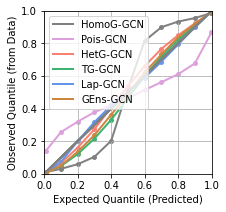

In [103]:
# verify this is correct
fig, ax = plt.subplots(figsize=(3,3))
# print("AA & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_test_ens_mean, aa_test_ens_std, target, dist="norm")))

print("HomoG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gcn_homog_mean, bb_gcn_homog_std, target, dist="norm_homo", 
                                                             ax=ax, label='HomoG-GCN')))
print("Pois-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gcn_pois_mean, None, target, dist="poisson", 
                                                            ax=ax, label='Pois-GCN')))
print("HetG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gcn_hetg_mean, bb_gcn_hetg_std, target, dist="norm", 
                                                             ax=ax, label='HetG-GCN')))
print("TG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gcn_tg_mean, bb_gcn_tg_std, target, dist="tnorm", 
                                                             ax=ax, label='TG-GCN')))
print("Lap-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gcn_lap_mean, bb_gcn_lap_std, target, dist="laplace", 
                                                            ax=ax, label='Lap-GCN')))
print("GEns-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gcn_test_ens_mean, bb_gcn_test_ens_std, target, dist="norm_ens", 
                                                             ax=ax, label='GEns-GCN')))
ax.grid()
fig.savefig(project_dir+"figures/final/before_gcn_calibration.png", bbox_inches='tight')




## 1.2 GAT Models

In [16]:
# GEns-GAT 
save_dir = project_dir+"models/220421_before_GAT_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
lookback = 4
b_ensemble_model_numbers = [102, 17, 52, 43, 45]

dist = 'norm'
criterion = MVELoss('norm')
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)

b_ts_test, b_y_test_eval, bb_test_ens_mean_gat, bb_test_ens_std_gat, bb_ens_mean_list_gat, bb_ens_std_list_gat = \
    util_gat.ensemble(project_dir, save_dir, 'before', predict_hzn, time_size, lookback, 
                       b_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter)


In [17]:
# HeteroG
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)

out_folder = "220421"
save_dir = project_dir+"models/"+out_folder+"_before_GAT_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gat_hetg_mean, bb_gat_hetg_std = load_and_run_gat(dist='norm', ii=12, save_dir=save_dir, model_period='before')


In [18]:
# HomoG
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)

target_train = np.squeeze(data['y'][0])[:,downtown_filter]
std = torch.tensor([np.mean(target_train) * 0.2])
save_dir = project_dir+"models/220519_before_GAT_norm_homo/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gat_homog_mean, bb_gat_homog_std = load_and_run_gat(dist='norm_homo', ii=12, 
                                                       save_dir=save_dir, model_period='before', std=std)


In [20]:
# TG-GAT
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220421_before_GAT_tnorm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gat_tg_mean, bb_gat_tg_std = load_and_run_gat(dist='tnorm', ii=110, save_dir=save_dir, model_period='before')


In [21]:
# Pois-GAT
## Poisson has a glitch. Although variance parameters are not used, the model was created with those parameters.
lookback = 4
criterion = MVELoss('poisson')
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)

save_dir = project_dir+"models/220421_before_GAT_poisson/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gat_pois_mean, bb_gat_pois_std = load_and_run_gat(dist='poisson', ii=115, save_dir=save_dir, model_period='before')

In [22]:
# Lap
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('laplace')
save_dir = project_dir+"models/220421_before_GAT_laplace/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
bb_gat_lap_mean, bb_gat_lap_std = load_and_run_gat(dist='norm', ii=49, save_dir=save_dir, model_period='before')


HomoG-GAT & 131.76 & 0.119 & 385.69 & 0.95 & 64.50
Pois-GAT & 190.33 & 0.125 & 65.61 & 0.60 & 62.36
HetG-GAT & 94.79 & 0.028 & 383.87 & 0.95 & 67.49
TG-GCN & 93.77 & 0.052 & 495.79 & 0.98 & 68.42
Lap-GAT & 92.72 & 0.019 & 383.93 & 0.97 & 67.52
GEns-GAT & 93.46 & 0.043 & 440.64 & 0.97 & 66.26


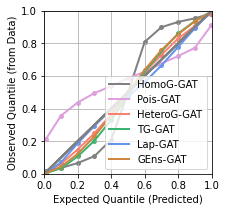

In [25]:
# verify this is correct
# print("AA & %.2f & %.2f & %.2f & %.2f" % (evall(aa_test_ens_mean, aa_test_ens_std, target, dist="norm")))
fig, ax = plt.subplots(figsize=(3,3))

print("HomoG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gat_homog_mean, bb_gat_homog_std, target, dist="norm_homo",
                                                             ax=ax, label='HomoG-GAT')))
print("Pois-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gat_pois_mean, None, target, dist="poisson", 
                                                            ax=ax, label='Pois-GAT')))
print("HetG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gat_hetg_mean, bb_gat_hetg_std, target, dist="norm",
                                                             ax=ax, label='HeteroG-GAT')))
print("TG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gat_tg_mean, bb_gat_tg_std, target, dist="tnorm", 
                                                             ax=ax, label='TG-GAT')))
print("Lap-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_gat_lap_mean, bb_gat_lap_std, target, dist="laplace",
                                                            ax=ax, label='Lap-GAT')))
print("GEns-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(bb_test_ens_mean_gat, bb_test_ens_std_gat, target, dist="norm_ens",
                                                            ax=ax, label='GEns-GAT')))
ax.grid()
fig.savefig(project_dir+"figures/final/before_gat_calibration.png", bbox_inches='tight')



# 2. After

In [144]:
# Get Data
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)

(num_train, _, _, n_modes) = data['x'][0].shape
(num_test, _, _, _) = data['x'][1].shape
n_stations = np.sum(downtown_filter)

ts_test = data['ts'][1]
target = np.squeeze(data['y'][-1])[:,downtown_filter]

max_station = np.argmax(np.mean(data['y'][1][:,:,downtown_filter], axis=0))
min_station = np.argmin(np.mean(data['y'][1][:,:,downtown_filter], axis=0))


## 2.1 GCN Models

In [27]:
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('norm')
a_ensemble_model_numbers = [17,29,25,54,18]
save_dir = project_dir+"models/220405_after_"+dist+"/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
# model period = data period = after
_, _, aa_test_ens_mean_gcn, aa_test_ens_std_gcn, aa_ens_mean_list, aa_ens_std_list = \
    util_gcnn.ensemble(project_dir, save_dir, 'after', predict_hzn, time_size, lookback, 
                       a_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter)


In [28]:
# HetG-GCN
lookback = 2
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220405_after_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gcn_hetg_mean, aa_gcn_hetg_std = load_and_run_gcn(dist='norm', ii=60, save_dir=save_dir, model_period='after')


In [145]:
# HomoG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
target_train = np.squeeze(data['y'][0])[:,downtown_filter]
std = torch.tensor([np.mean(target_train) * 0.45])
save_dir = project_dir+"models/220520_after_norm_homo/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gcn_homog_mean, aa_gcn_homog_std = load_and_run_gcn(dist='norm_homo', ii=5, 
                                                       save_dir=save_dir, model_period='after', std=std)


In [45]:
# TG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220405_after_tnorm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gcn_tg_mean, aa_gcn_tg_std = load_and_run_gcn(dist='tnorm', ii=19, save_dir=save_dir, model_period='after')


In [31]:
# Lap-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('laplace')
save_dir = project_dir+"models/220405_after_laplace/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gcn_lap_mean, aa_gcn_lap_std = load_and_run_gcn(dist='laplace', ii=21, save_dir=save_dir, model_period='after')

In [32]:
# Pois-GCN
criterion = MVELoss('poisson')
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
lookback=2
save_dir = project_dir+"models/220405_after_poisson/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gcn_pois_mean, aa_gcn_pois_std = load_and_run_gcn(dist='poisson', ii=23, save_dir=save_dir, model_period='after')

HomoG-GCN & 84.16 & 0.101 & 88.45 & 0.96 & 13.72
Pois-GCN & 90.14 & 0.085 & 27.82 & 0.74 & 13.80
HetG-GCN & 70.89 & 0.026 & 75.31 & 0.96 & 13.14
TG-GCN & 70.86 & 0.024 & 73.51 & 0.96 & 13.41
Lap-GCN & 71.32 & 0.030 & 77.27 & 0.97 & 13.71
GEns-GCN & 70.83 & 0.026 & 73.04 & 0.96 & 13.55


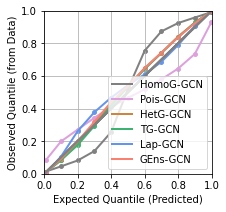

In [46]:
# verify this is correct
fig, ax = plt.subplots(figsize=(3,3))
# print("aa_ & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa__test_ens_mean, aa__test_ens_std, target, dist="norm")))

print("HomoG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gcn_homog_mean, aa_gcn_homog_std, target, dist="norm_homo", 
                                                             ax=ax, label='HomoG-GCN')))
print("Pois-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gcn_pois_mean, None, target, dist="poisson", 
                                                            ax=ax, label='Pois-GCN')))
print("HetG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gcn_hetg_mean, aa_gcn_hetg_std, target, dist="norm_ens", 
                                                             ax=ax, label='HetG-GCN')))
print("TG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gcn_tg_mean, aa_gcn_tg_std, target, dist="tnorm", 
                                                             ax=ax, label='TG-GCN')))
print("Lap-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gcn_lap_mean, aa_gcn_lap_std, target, dist="laplace", 
                                                            ax=ax, label='Lap-GCN')))
print("GEns-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_test_ens_mean_gcn, aa_test_ens_std_gcn, target, dist="norm", 
                                                             ax=ax, label='GEns-GCN')))

ax.grid()
fig.savefig(project_dir+"figures/final/after_gcn_calibration.png", bbox_inches='tight')


## 2.2 GAT Models

In [47]:
lookback = 4
save_dir = project_dir+"models/220421_after_GAT_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
a_ensemble_model_numbers = [50, 52, 59, 57, 43]
_, _, aa_test_ens_mean_gat, aa_test_ens_std_gat, aa_ens_mean_list_gat, aa_ens_std_list_gat = \
    util_gat.ensemble(project_dir, save_dir, "after", predict_hzn, time_size, lookback, 
                       a_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter)

In [48]:
# HetG-GAT
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220421_after_GAT_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gat_hetg_mean, aa_gat_hetg_std = load_and_run_gat(dist='norm', ii=50, save_dir=save_dir, model_period='after')


In [49]:
# HomoG-gat
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
target_train = np.squeeze(data['y'][0])[:,downtown_filter]
std = torch.tensor([np.mean(target_train) * 0.45])
save_dir = project_dir+"models/220520_after_GAT_norm_homo/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gat_homog_mean, aa_gat_homog_std = load_and_run_gat(dist='norm_homo', ii=48, 
                                                       save_dir=save_dir, model_period='after', std=std)


In [53]:
# Lap-gat
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('laplace')
save_dir = project_dir+"models/220421_after_GAT_laplace/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gat_lap_mean, aa_gat_lap_std = load_and_run_gat(dist='laplace', ii=19, save_dir=save_dir, model_period='after')

In [50]:
# TG-GAT
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220421_after_GAT_tnorm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gat_tg_mean, aa_gat_tg_std = load_and_run_gat(dist='tnorm', ii=35, save_dir=save_dir, model_period='after')


In [51]:
# Pois-gat
criterion = MVELoss('poisson')
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
lookback=4
save_dir = project_dir+"models/220421_after_GAT_poisson/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
aa_gat_pois_mean, aa_gat_pois_std = load_and_run_gat(dist='poisson', ii=63, save_dir=save_dir, model_period='after')

HomoG-GAT & 82.77 & 0.101 & 88.63 & 0.96 & 13.17
Pois-GAT & 89.03 & 0.084 & 29.01 & 0.75 & 13.32
HetG-GAT & 71.09 & 0.015 & 71.19 & 0.95 & 13.57
TG-GAT & 71.18 & 0.021 & 73.03 & 0.96 & 13.98
Lap-GAT & 71.29 & 0.023 & 83.38 & 0.97 & 13.53
GEns-GAT & 70.92 & 0.034 & 69.10 & 0.95 & 13.48


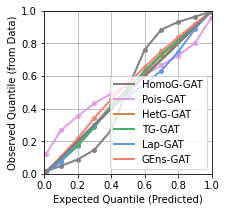

In [54]:
# verify this is correct
fig, ax = plt.subplots(figsize=(3,3))
# print("aa_ & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa__test_ens_mean, aa__test_ens_std, target, dist="norm")))

print("HomoG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gat_homog_mean, aa_gat_homog_std, target, dist="norm_homo", 
                                                             ax=ax, label='HomoG-GAT')))
print("Pois-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gat_pois_mean, None, target, dist="poisson", 
                                                            ax=ax, label='Pois-GAT')))
print("HetG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gat_hetg_mean, aa_gat_hetg_std, target, dist="norm_ens", 
                                                             ax=ax, label='HetG-GAT')))
print("TG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gat_tg_mean, aa_gat_tg_std, target, dist="tnorm", 
                                                             ax=ax, label='TG-GAT')))
print("Lap-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_gat_lap_mean, aa_gat_lap_std, target, dist="laplace", 
                                                            ax=ax, label='Lap-GAT')))
print("GEns-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_test_ens_mean_gat, aa_test_ens_std_gat, target, dist="norm", 
                                                             ax=ax, label='GEns-GAT')))
ax.grid()
fig.savefig(project_dir+"figures/final/after_GAT_calibration.png", bbox_inches='tight')


# 3. Before-After

In [104]:
# Get Data
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)

(num_train, _, _, n_modes) = data['x'][0].shape
(num_test, _, _, _) = data['x'][1].shape
n_stations = np.sum(downtown_filter)

ts_test = data['ts'][1]
target = np.squeeze(data['y'][-1])[:,downtown_filter]

max_station = np.argmax(np.mean(data['y'][1][:,:,downtown_filter], axis=0))
min_station = np.argmin(np.mean(data['y'][1][:,:,downtown_filter], axis=0))


## 3.1 GCN Models

In [105]:
# GEns-GCN
lookback = 4
b_ensemble_model_numbers = [21,17,18,25,3]
dist = 'norm'
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('norm')
save_dir = project_dir+"models/220405_before_"+dist+"/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
a_ts_test, a_y_test_eval, ba_gcn_test_ens_mean, ba_gcn_test_ens_std, ba_gcn_ens_mean_list, ba_gcn_ens_std_list = \
    util_gcnn.ensemble(project_dir, save_dir, 'before', predict_hzn, time_size, lookback, 
                       b_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter)


In [106]:
# HetG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220405_before_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gcn_hetg_mean, ba_gcn_hetg_std = load_and_run_gcn(dist='norm', ii=29, save_dir=save_dir, model_period='before')


In [107]:
# TG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220405_before_tnorm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gcn_tg_mean, ba_gcn_tg_std = load_and_run_gcn(dist='tnorm', ii=16, save_dir=save_dir, model_period='before')


In [108]:
# HomoG-GCN
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)
target_train = np.squeeze(data['y'][0])[:,downtown_filter]
std = torch.tensor([np.mean(target_train) * 0.2])
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220519_before_norm_homo/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gcn_homog_mean, ba_gcn_homog_std = load_and_run_gcn(dist='norm_homo', ii=12, 
                                                       save_dir=save_dir, model_period='before', std=std)


In [109]:
# Lap-GCN
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('laplace')
save_dir = project_dir+"models/220405_before_laplace/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gcn_lap_mean, ba_gcn_lap_std = load_and_run_gcn(dist='laplace', ii=21, save_dir=save_dir, model_period='before')

In [110]:
# Pois-GCN
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('poisson')
save_dir = project_dir+"models/220405_before_poisson/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gcn_pois_mean, ba_gcn_pois_std = load_and_run_gcn(dist='poisson', ii=15, save_dir=save_dir, model_period='before')

HomoG-GCN & 102.68 & 0.194 & 302.02 & 1.00 & 14.53
Pois-GCN & 92.86 & 0.135 & 29.51 & 0.72 & 14.48
HetG-GCN & 74.02 & 0.096 & 102.35 & 0.99 & 14.64
TG-GCN & 72.57 & 0.068 & 95.39 & 0.99 & 13.64
Lap-GCN & 72.84 & 0.075 & 114.80 & 1.00 & 13.74
GEns-GCN & 73.31 & 0.088 & 97.72 & 0.99 & 14.30


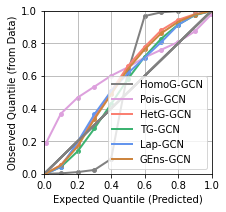

In [111]:
# verify this is correct
fig, ax = plt.subplots(figsize=(3,3))
# print("AA & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(aa_test_ens_mean, aa_test_ens_std, target, dist="norm")))

print("HomoG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gcn_homog_mean, ba_gcn_homog_std, target, dist="norm_homo", 
                                                             ax=ax, label='HomoG-GCN')))
print("Pois-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gcn_pois_mean, None, target, dist="poisson", 
                                                            ax=ax, label='Pois-GCN')))
print("HetG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gcn_hetg_mean, ba_gcn_hetg_std, target, dist="norm", 
                                                             ax=ax, label='HetG-GCN')))
print("TG-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gcn_tg_mean, ba_gcn_tg_std, target, dist="tnorm", 
                                                             ax=ax, label='TG-GCN')))
print("Lap-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gcn_lap_mean, ba_gcn_lap_std, target, dist="laplace", 
                                                            ax=ax, label='Lap-GCN')))
print("GEns-GCN & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gcn_test_ens_mean, ba_gcn_test_ens_std, target, dist="norm_ens", 
                                                             ax=ax, label='GEns-GCN')))
ax.grid()
# fig.savefig(project_dir+"figures/final/before_after_gcn_calibration.png", bbox_inches='tight')



In [138]:
color_norm = util_plot.MidpointNormalize(vmin=-100, vmax = 100, midpoint=0)

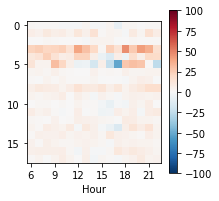

In [142]:
test_ens_residuals = ba_gcn_test_ens_mean - target
stu = pd.DataFrame(test_ens_residuals[5:], index=a_ts_test[5:], columns = data['stations'])
stu['hour'] = stu.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(stu.groupby('hour').mean().to_numpy().T, cmap = 'RdBu_r', norm=color_norm)
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar()
# fig.savefig(project_dir+"figures/"+out_folder+"/before_st_outlier.png", bbox_inches='tight');


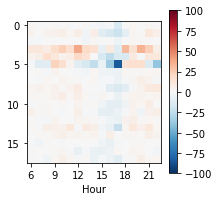

In [141]:
test_ens_residuals = aa_test_ens_mean_gcn - target
stu = pd.DataFrame(test_ens_residuals[5:], index=a_ts_test[5:], columns = data['stations'])
stu['hour'] = stu.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(stu.groupby('hour').mean().to_numpy().T, cmap = 'RdBu_r', 
           norm=color_norm)
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar()
# fig.savefig(project_dir+"figures/"+out_folder+"/before_st_outlier.png", bbox_inches='tight');


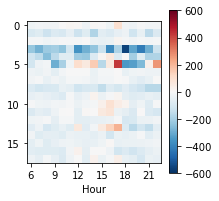

In [131]:
test_hetg_residuals = target - ba_gcn_hetg_mean
stu = pd.DataFrame(test_hetg_residuals[5:], index=a_ts_test[5:], columns = data['stations'])
stu['hour'] = stu.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(stu.groupby('hour').sum().to_numpy().T, cmap = 'RdBu_r', norm=color_norm)
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar()
# fig.savefig(project_dir+"figures/"+out_folder+"/before_st_outlier.png", bbox_inches='tight');


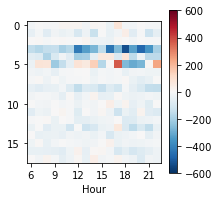

In [132]:
test_lap_residuals = target - ba_gcn_lap_mean
stu = pd.DataFrame(test_lap_residuals[5:], index=a_ts_test[5:], columns = data['stations'])
stu['hour'] = stu.index % 24

fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(stu.groupby('hour').sum().to_numpy().T, cmap = 'RdBu_r', norm=color_norm)
ax.set_xticks(np.arange(0, 18, 3))
ax.set_xticklabels(np.arange(6, 23, 3))
# ax.set_yticks(np.arange(len(data['stations'])))
# ax.set_yticklabels([downtown_stations[downtown_stations['STATION_ID']==x].iloc[0]['LONGNAME'] for x in data['stations']]);
ax.set_xlabel("Hour");
plt.colorbar()
# fig.savefig(project_dir+"figures/"+out_folder+"/before_st_outlier.png", bbox_inches='tight');



## 3.2 GAT Models

In [76]:
# GEns-GAT 
save_dir = project_dir+"models/220421_before_GAT_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
lookback = 4
b_ensemble_model_numbers = [102, 17, 52, 43, 45]

dist = 'norm'
criterion = MVELoss('norm')
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)

a_ts_test, a_y_test_eval, ba_test_ens_mean_gat, ba_test_ens_std_gat, ba_ens_mean_list_gat, ba_ens_std_list_gat = \
    util_gat.ensemble(project_dir, save_dir, 'before', predict_hzn, time_size, lookback, 
                       b_ensemble_model_numbers, device, train_extent, adj_type,
                       data, adj, spatial, downtown_filter)


In [86]:
# HeteroG
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)

out_folder = "220421"
save_dir = project_dir+"models/"+out_folder+"_before_GAT_norm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gat_hetg_mean, ba_gat_hetg_std = load_and_run_gat(dist='norm', ii=12, save_dir=save_dir, model_period='before')


In [87]:
# HomoG
lookback = 6
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'before', predict_hzn, time_size, difference, max_lookback, lookback)

target_train = np.squeeze(data['y'][0])[:,downtown_filter]
std = torch.tensor([np.mean(target_train) * 0.2])
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220519_before_GAT_norm_homo/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gat_homog_mean, ba_gat_homog_std = load_and_run_gat(dist='norm_homo', ii=12, 
                                                       save_dir=save_dir, model_period='before', std=std)


In [88]:
# TG-GAT
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
save_dir = project_dir+"models/220421_before_GAT_tnorm/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gat_tg_mean, ba_gat_tg_std = load_and_run_gat(dist='tnorm', ii=110, save_dir=save_dir, model_period='before')


In [89]:
# Pois-GAT
## Poisson has a glitch. Although variance parameters are not used, the model was created with those parameters.
lookback = 4
criterion = MVELoss('poisson')
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)

save_dir = project_dir+"models/220421_before_GAT_poisson/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gat_pois_mean, ba_gat_pois_std = load_and_run_gat(dist='poisson', ii=115, save_dir=save_dir, model_period='before')

In [90]:
# Lap
lookback = 4
data, adj, spatial, downtown_filter = \
    util_gcnn.combine_datasources(project_dir, 'after', predict_hzn, time_size, difference, max_lookback, lookback)
criterion = MVELoss('laplace')
save_dir = project_dir+"models/220421_before_GAT_laplace/"
save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)
ba_gat_lap_mean, ba_gat_lap_std = load_and_run_gat(dist='norm', ii=49, save_dir=save_dir, model_period='before')


HomoG-GAT & 102.76 & 0.185 & 301.53 & 1.00 & 16.12
Pois-GAT & 100.39 & 0.217 & 30.30 & 0.68 & 16.07
HetG-GAT & 74.85 & 0.117 & 97.28 & 0.98 & 15.68
TG-GAT & 73.26 & 0.076 & 93.79 & 0.99 & 13.86
Lap-GAT & 72.76 & 0.070 & 111.95 & 0.99 & 13.82
GEns-GAT & 73.66 & 0.091 & 96.65 & 0.99 & 14.14


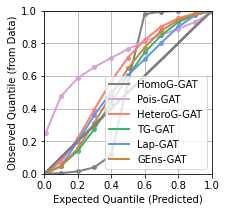

In [91]:
# verify this is correct
# print("AA & %.2f & %.2f & %.2f & %.2f" % (evall(aa_test_ens_mean, aa_test_ens_std, target, dist="norm")))
fig, ax = plt.subplots(figsize=(3,3))

print("HomoG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gat_homog_mean, ba_gat_homog_std, target, dist="norm_homo",
                                                             ax=ax, label='HomoG-GAT')))
print("Pois-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gat_pois_mean, None, target, dist="poisson", 
                                                            ax=ax, label='Pois-GAT')))
print("HetG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gat_hetg_mean, ba_gat_hetg_std, target, dist="norm",
                                                             ax=ax, label='HeteroG-GAT')))
print("TG-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gat_tg_mean, ba_gat_tg_std, target, dist="tnorm", 
                                                             ax=ax, label='TG-GAT')))
print("Lap-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_gat_lap_mean, ba_gat_lap_std, target, dist="laplace",
                                                            ax=ax, label='Lap-GAT')))
print("GEns-GAT & %.2f & %.3f & %.2f & %.2f & %.2f" % (evall(ba_test_ens_mean_gat, ba_test_ens_std_gat, target, dist="norm_ens",
                                                            ax=ax, label='GEns-GAT')))
ax.grid()
fig.savefig(project_dir+"figures/final/before_after_gat_calibration.png", bbox_inches='tight')

